Prototype WIP.

# Topic Evaluation

Evaluate topic assignment to Posts.

In [1]:
import os, ast

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23

## Loading

In [3]:
data_path = "/mnt/DATA/NRW2019 Dropbox/data 4good/CSVData"
model_path = "../models"
figures_path = "../reports/figures/"

In [4]:
topics40_fpath = os.path.join(data_path, "topics", "topics.csv")
topics30_fpath = os.path.join(data_path, "topics", "topics_n30.csv")

topics40 = pd.read_csv(topics40_fpath)
topics30 = pd.read_csv(topics30_fpath)

assert topics40.shape == topics30.shape, "Shape mismatch of topic tables"

print("Topics n40", topics40.shape)
print("Topics n30", topics30.shape)

Topics n40 (22534, 4)
Topics n30 (22534, 4)


## Exploration

NaN Stats

In [5]:
topics40.isna().sum()

text                  0
textID                0
topic_distribution    0
topic                 0
dtype: int64

In [6]:
topics30.isna().sum()

text                  0
textID                0
topic_distribution    0
topic                 0
dtype: int64

Duplicated texts (after cleaning)

In [7]:
topics40.text.duplicated().value_counts()

False    22534
Name: text, dtype: int64

In [8]:
topics30.text.duplicated().value_counts()

False    22534
Name: text, dtype: int64

Duplicated textIDs

In [9]:
topics40.textID.duplicated().value_counts()

False    22534
Name: textID, dtype: int64

In [10]:
topics30.textID.duplicated().value_counts()

False    22534
Name: textID, dtype: int64

Topics

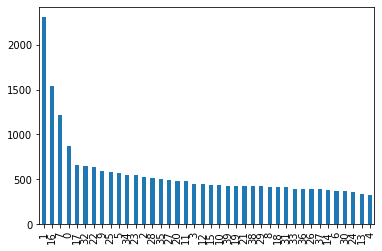

In [11]:
topics40.topic.value_counts().plot(kind="bar")

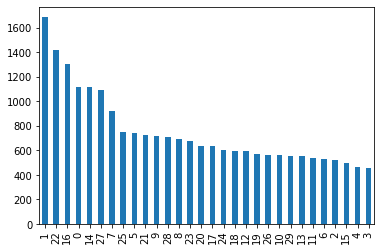

In [12]:
topics30.topic.value_counts().plot(kind="bar")

Top-10 Posts per Topic

In [13]:
def get_top_10(df, topic, topic_range):
    topic_subset = df[df.topic == topic].copy()
    topic_subset.topic_distribution = topic_subset.topic_distribution.apply(ast.literal_eval)
    flattend_subset = pd.concat([topic_subset,
                                 pd.DataFrame(topic_subset.topic_distribution.values.tolist(),
                                              index=topic_subset.index, columns=topic_range)],
                                axis=1)
    return flattend_subset.sort_values(by=[1], ascending=False).text.head(10)

In [14]:
topics40_top10_fp = "../reports/topics/topics_40_top-10.txt"
topic_range = range(0, 40)

with open(topics40_top10_fp, "w") as f:
    for i in topic_range:
        with pd.option_context("display.max_colwidth", -1):
            f.write("Topic " + str(i) + ":\n" + get_top_10(topics40, i, topic_range).to_string(index=False) + "\n\n")

In [15]:
topics30_top10_fp = "../reports/topics/topics_30_top-10.txt"
topic_range = range(0, 30)

with open(topics30_top10_fp, "w") as f:
    for i in topic_range:
        with pd.option_context("display.max_colwidth", -1):
            f.write("Topic " + str(i) + ":\n" + get_top_10(topics30, i, topic_range).to_string(index=False) + "\n\n")

# Conclusion

